# Two Model Uplift (Baseline)

Create a model that predicts the increase of probability of conversion after treatment:

$$
\text{Uplift (X) =   } P(Y = 1| T = 1| X) - P(Y = 1 | T = 0 | X)
$$

User types from an uplift perspective:

- Always convert: Users who would convert regardless of receiving the treatment. Applying the treatment is unnecessary and would waste resources.

- Never convert: Users who will not convert whether they receive the treatment or not. The treatment is irrelevant and targeting them is also a waste of resources.

- Persuadable: Users who convert only if they receive the treatment. These are the ideal targets for the campaign, as they generate incremental impact.

- Negative responders: Users who convert without treatment but fail to convert if exposed to it. Targeting these users carries risk of lost conversions.

In [9]:
import numpy as np 
import pandas as pd 

DATA_PATH = '../data/raw/criteo-uplift-v2.1.csv'

df = pd.read_csv(DATA_PATH)

# df.drop(columns = ['f4','f8','f9','f10'], inplace = True)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,13979592.0,19.620297,5.377464,12.616365,12.616365,21.923413,24.436459,26.745255
f1,13979592.0,10.069977,0.104756,10.059654,10.059654,10.059654,10.059654,16.344187
f2,13979592.0,8.446582,0.299316,8.214383,8.214383,8.214383,8.723335,9.051962
f3,13979592.0,4.178923,1.336645,-8.398387,4.679882,4.679882,4.679882,4.679882
f4,13979592.0,10.338837,0.343308,10.280525,10.280525,10.280525,10.280525,21.123508
f5,13979592.0,4.028513,0.431097,-9.011892,4.115453,4.115453,4.115453,4.115453
f6,13979592.0,-4.155356,4.577914,-31.429784,-6.699321,-2.411115,0.294443,0.294443
f7,13979592.0,5.101765,1.205248,4.833815,4.833815,4.833815,4.833815,11.998401
f8,13979592.0,3.933581,0.056660,3.635107,3.910792,3.971858,3.971858,3.971858
f9,13979592.0,16.027638,7.018975,13.190056,13.190056,13.190056,13.190056,75.295017


For the two model uplift approach is necessary to split both treated and control group

In [10]:
# Split control and treatment
df_control = df[df['treatment'] == 0].copy()
df_treatment = df[df['treatment'] == 1].copy()

# Define the features and the target
features = [col for col in df.columns if col.startswith('f')]  
target = 'conversion'


This baseline model is another Logistic Classifier due to its simplicity and understability

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Control model
X_c = df_control[features]
y_c = df_control[target]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42, stratify=y_c)

model_control = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=500))])
model_control.fit(Xc_train, yc_train)

# Treatment model
X_t = df_treatment[features]
y_t = df_treatment[target]

Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42, stratify=y_t)

model_treatment = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=500))])
model_treatment.fit(Xt_train, yt_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

Having both models we can predict the probability of conversion "with" and "without" the treatment given some features (X); and calculate the difference between both (uplift)

In [12]:
# Probability prediction
df['p_control'] = model_control.predict_proba(df[features])[:,1]
df['p_treatment'] = model_treatment.predict_proba(df[features])[:,1]

# Uplift = P(Y=1 | T=1) - P(Y=1 | T=0)
df['uplift_score'] = df['p_treatment'] - df['p_control']


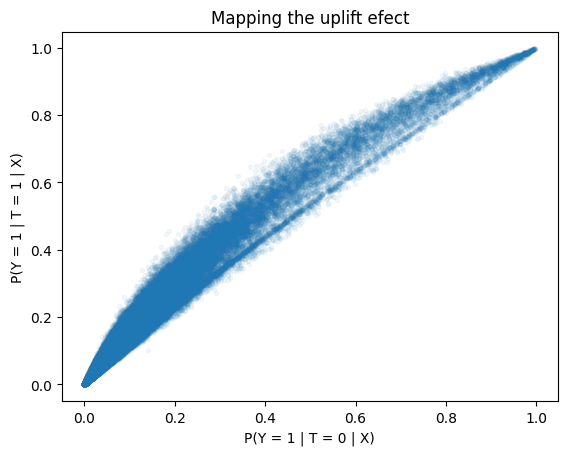

In [13]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['p_control'], df['p_treatment'],'.', alpha = 0.05)
plt.title('Mapping the uplift efect')
plt.xlabel('P(Y = 1 | T = 0 | X)')
plt.ylabel('P(Y = 1 | T = 1 | X)')
plt.show()

The above graph shows three different sections:
- Points below the diagonal have negative uplift ("Negative responders"). In this scenario there aren't any, that's another indicator that this datset is synthetic and unreal
- Points in the diagonal are unsensible to the treatment. Those with high P(Y = 1) will convert anyway ("Always convert") and those with low P(Y = 1) won't convert ("Never convert")
- Points above the diagonal have a positive uplift and are the main target of the marketing campaign ("Persuadable")


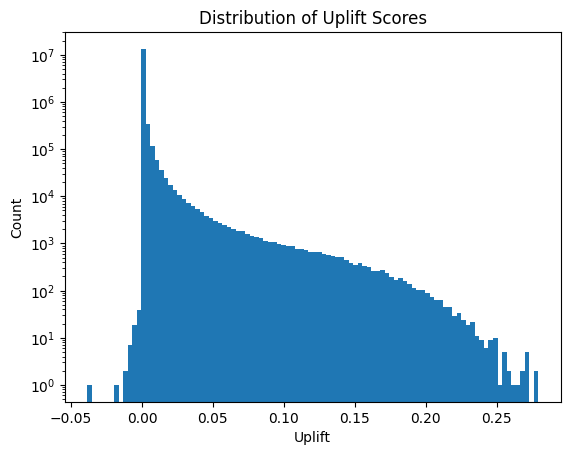

In [14]:
plt.figure()
plt.hist(df['uplift_score'], bins=100, log = True)
plt.title('Distribution of Uplift Scores')
plt.xlabel('Uplift')
plt.ylabel('Count')
plt.show()


- The vast majority of users have uplift close to zero, meaning that for most users the treatment has no incremental effect.  
- Users with uplift significantly above zero represent the “persuadable” segment and they are the ideal targets for marketing interventions.  
- There are no negative responders in this dataset, which is expected given the synthetic/academic nature of the data.  
- This distribution highlights the heterogeneity of treatment effects and justifies targeting users based on predicted uplift rather than overall conversion probability.  


For evaluation, we compute the uplift score for the test set only, using the treatment and control models trained separately. This ensures that the metrics reflect out-of-sample incremental effect, avoiding overfitting

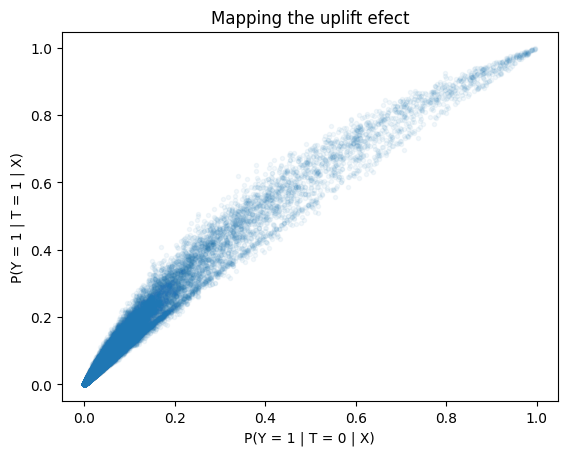

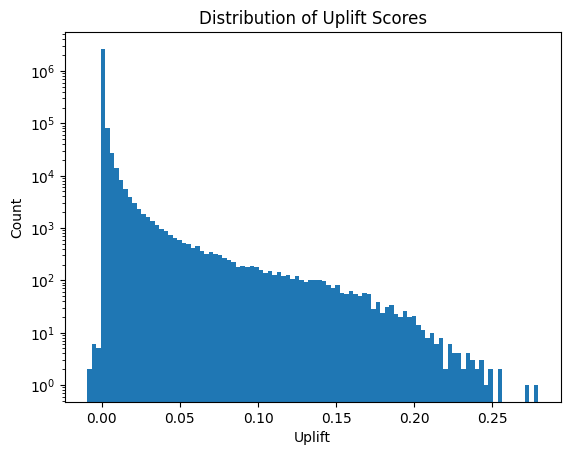

In [15]:
# Join together both test dataset:
Xt_test = Xt_test.reset_index(drop=True)
Xc_test = Xc_test.reset_index(drop=True)
yt_test = yt_test.reset_index(drop=True)
yc_test = yc_test.reset_index(drop=True)

X_test = pd.concat([Xt_test, Xc_test], axis=0).reset_index(drop=True)
y_test = pd.concat([yt_test, yc_test], axis=0).reset_index(drop=True)

df_test = pd.concat([X_test, y_test], axis=1)

treatment = pd.Series([1]*len(Xt_test) + [0]*len(Xc_test))
df_test['treatment'] = treatment

df_test['p_control'] = model_control.predict_proba(df_test[features])[:,1]
df_test['p_treatment'] = model_treatment.predict_proba(df_test[features])[:,1]

df_test['uplift_score'] = df_test['p_treatment'] - df_test['p_control']

# Mapping the uplift effect for test df
plt.figure()
plt.plot(df_test['p_control'], df_test['p_treatment'],'.', alpha = 0.05)
plt.title('Mapping the uplift efect')
plt.xlabel('P(Y = 1 | T = 0 | X)')
plt.ylabel('P(Y = 1 | T = 1 | X)')
plt.show()

# Distribution of uplift for test df
plt.figure()
plt.hist(df_test['uplift_score'], bins=100, log = True)
plt.title('Distribution of Uplift Scores')
plt.xlabel('Uplift')
plt.ylabel('Count')
plt.show()



We evaluate the uplift model by ranking users according to predicted uplift and comparing conversion rates between treated and control users across increasing population segments. This allows us to assess whether the model successfully concentrates treatment on users with higher incremental response.

In [16]:
# Sort the uplift scores descending
df_sorted = df_test.sort_values('uplift_score', ascending=False).reset_index(drop=True)
print(df_sorted['uplift_score'])

0          0.279176
1          0.271295
2          0.254065
3          0.253465
4          0.249306
             ...   
2795914   -0.005757
2795915   -0.005798
2795916   -0.006272
2795917   -0.006649
2795918   -0.009350
Name: uplift_score, Length: 2795919, dtype: float64


Individual counterfactuals are unobservable, so uplift models are evaluated through aggregated group-level comparisons.

### Uplift curve

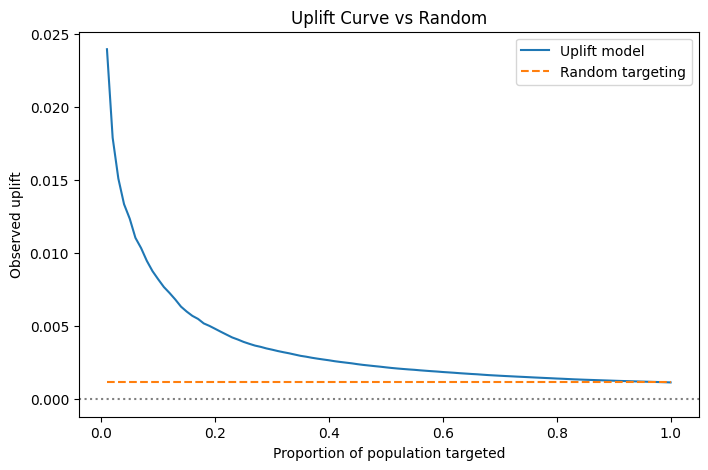

In [17]:
# Select different percentiles
percentiles = np.linspace(0.01, 1, 100)  
uplift_values = []

# random selection (equal to select the whole dataset)
global_treat_rate = df_test[df_test['treatment'] == 1]['conversion'].mean()
global_ctrl_rate = df_test[df_test['treatment'] == 0]['conversion'].mean()

global_uplift = global_treat_rate - global_ctrl_rate

random_uplift = [global_uplift] * len(percentiles)



for p in percentiles:
    # select only the top-p percentile
    k = int(p * len(df_sorted))
    subset = df_sorted.iloc[:k]
    
    # divide into treated - control groups
    treated = subset[subset['treatment'] == 1]
    control = subset[subset['treatment'] == 0]
    
    # calculate the average conversion for each group
    treat_rate = treated['conversion'].mean()
    control_rate = control['conversion'].mean()
    
    # calculate the difference
    uplift = treat_rate - control_rate
    uplift_values.append(uplift)


plt.figure(figsize=(8,5))
plt.plot(percentiles, uplift_values, label='Uplift model')
plt.plot(percentiles, random_uplift, '--', label='Random targeting')
plt.axhline(0, linestyle=':', color='grey')
plt.xlabel('Proportion of population targeted')
plt.ylabel('Observed uplift')
plt.title('Uplift Curve vs Random')
plt.legend()
plt.show()




This graph shows that model, even being so simple, is quite good at sorting the uplift potencial of the users so we can target only some specific percentile based on their increase of conversion.

The small oscillations in the first percentiles are due to high variance when estimating uplift on very small samples of a rare event (1% - 3%). This effect stabilizes quickly as the sample size increases (higher percentiles)

### Qini Curve

The Qini curve is another visualization of the incremental effect of the treatment. Indeed, it is the curve that measures the area between the blue *sorted uplift curve* and the orange *random uplift targeting* curve form the above graph. 

A good model will have its curve above the random allocation line, showing that it correctly identifies "persuadable" users.


Random uplift at any percentile: 0.0012


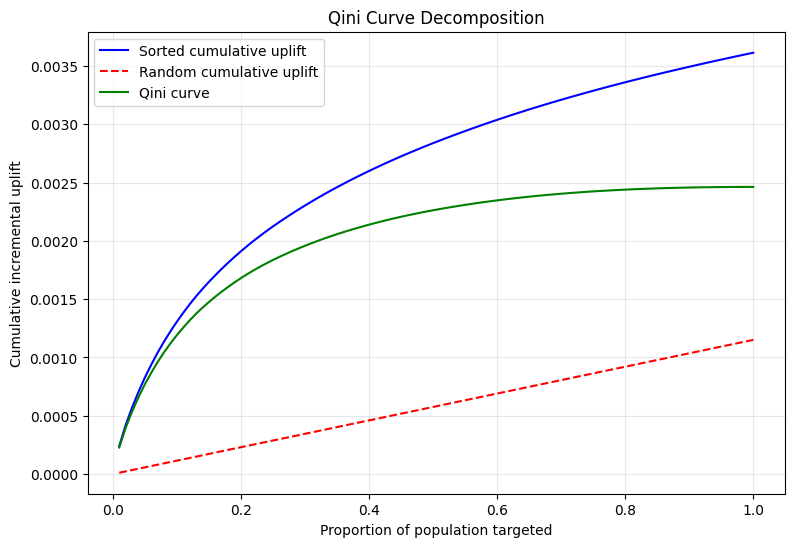

In [18]:
# Convert to numpy arrays
uplift_values = np.array(uplift_values)
random_uplift = np.array(random_uplift)

# Paso entre percentiles (asumimos espaciado uniforme)
delta_p = percentiles[1] - percentiles[0]

# Sorted cumulative uplift (integral de uplift curve)
sorted_cum_uplift = np.cumsum(uplift_values * delta_p)

# Random cumulative uplift (integral de random uplift)
random_cum_uplift = np.cumsum(random_uplift * delta_p)
print(f'Random uplift at any percentile: {random_uplift[0]:.4f}')

# Qini curve = difference
qini_curve = sorted_cum_uplift - random_cum_uplift

# Plot
plt.figure(figsize=(9,6))
plt.plot(percentiles, sorted_cum_uplift, label='Sorted cumulative uplift', color='blue')
plt.plot(percentiles, random_cum_uplift, '--', label='Random cumulative uplift', color='red')
plt.plot(percentiles, qini_curve, label='Qini curve', color='green')

plt.xlabel('Proportion of population targeted')
plt.ylabel('Cumulative incremental uplift')
plt.title('Qini Curve Decomposition')
plt.legend()
plt.grid(alpha=0.3)
plt.show()




In [19]:
# Qini coefficient = Qini surface
qini_coefficient = np.sum(qini_curve * delta_p)

print(f'Qini coefficient: {qini_coefficient:.6f}')



Qini coefficient: 0.002041


The absolute Qini value depends on the base conversion rate and uplift magnitude, so it is typically small. What matters is its sign and its relative comparison across models.

### Conclusions

The uplift curve shows that the top-ranked percentiles deliver substantially higher observed uplift than the population average, confirming that the model is able to concentrate incremental conversions in a small fraction of users.

Random targeting provides a flat baseline uplift, which represents the expected incremental gain when no personalization is applied. The fact that the model uplift curve dominates this baseline indicates positive business value.

The Qini curve and Qini coefficient quantify the cumulative gain obtained by ordered targeting versus random targeting. A positive Qini coefficient confirms that the model improves decision-making beyond chance. Although the absolute Qini value is small, this is expected given the low base conversion rate and the rare-event nature of the problem. The metric is intended for relative model comparison, not for absolute interpretation.

This framework supports data-driven decisions about how much of the population to target, enabling future extensions such as cost–benefit optimization and campaign budget allocation.

In [20]:
import joblib

# Guardar modelos
joblib.dump(model_treatment, 'model_treatment.joblib')
joblib.dump(model_control, 'model_control.joblib')




['model_control.joblib']

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

DATA_PATH = '../data/processed/criteo-uplift-processed_sample20_sorted.parquet'

df_sorted = pd.read_parquet(DATA_PATH)



percentiles = np.linspace(0.01, 1.0, 100)

treat_rates = []
control_rates = []

N = len(df_sorted)

for p in percentiles:
    k = int(p * N)
    subset = df_sorted.iloc[:k]

    treat_rates.append(
        subset[subset["treatment"] == 1]["conversion"].mean()
    )
    control_rates.append(
        subset[subset["treatment"] == 0]["conversion"].mean()
    )

treat_rates = np.array(treat_rates)
control_rates = np.array(control_rates)


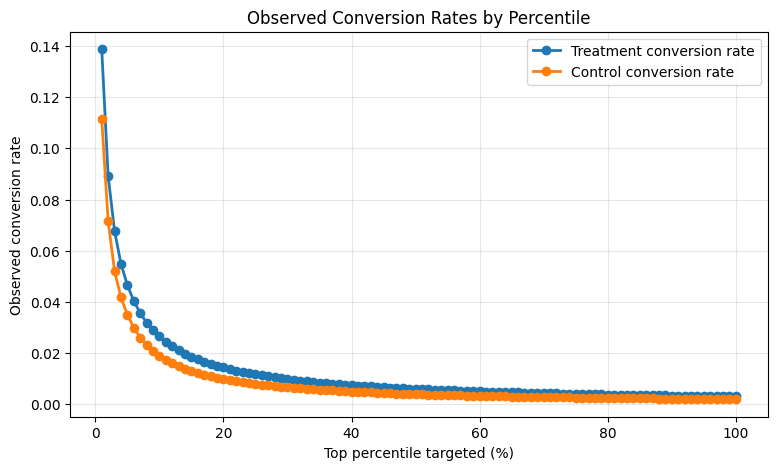

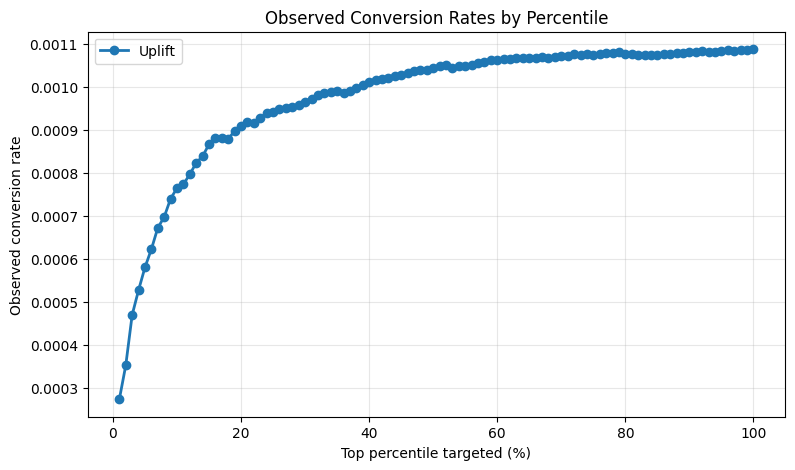

In [8]:
plt.figure(figsize=(9,5))

plt.plot(percentiles*100, treat_rates, label="Treatment conversion rate", linewidth=2, marker = 'o')
plt.plot(percentiles*100, control_rates, label="Control conversion rate", linewidth=2, marker = 'o')

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed conversion rate")
plt.title("Observed Conversion Rates by Percentile")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


plt.figure(figsize=(9,5))

# plt.plot(percentiles*100, (treat_rates - control_rates)*percentiles, label="Uplift", linewidth=2, marker = 'o')
plt.plot(percentiles*100, (treat_rates - control_rates)* percentiles, label="Uplift", linewidth=2, marker = 'o')

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed conversion rate")
plt.title("Observed Conversion Rates by Percentile")
plt.legend()
plt.grid(alpha=0.3)
# plt.ylim(0, 0.004)

plt.show()
